## libraries

In [15]:
import os
import sys
from pathlib import Path
from pprint import pformat
from tempfile import TemporaryDirectory
from datetime import datetime, timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import geopandas as gpd
import pooch
import flopy
import flopy.plot
import flopy.utils
import rasterio
from rasterio.features import rasterize
import contextily as cx
import re
from shapely.geometry import box
from shapely.geometry import Point
from shapely.geometry import LineString
from multiprocessing import Pool, cpu_count
import time
print(sys.version)
print(f"numpy version: {np.__version__}")
print(f"matplotlib version: {mpl.__version__}")
print(f"flopy version: {flopy.__version__}")

3.12.8 (main, Dec  4 2024, 14:07:02) [GCC 14.2.0]
numpy version: 1.26.4
matplotlib version: 3.10.0
flopy version: 3.9.2


## Create the GWF simulation

In [16]:
# simulation setup
sim_name = 'rgtihm'
workspace = './model'
sim = flopy.mf6.MFSimulation(
    sim_name=sim_name,
    sim_ws=workspace,
    exe_name='mf6')
gwf = flopy.mf6.ModflowGwf(sim,
                           modelname=sim_name)
print("simulation and gwf packages created.")

simulation and gwf packages created.


## Temporal Discretization (TDIS) Package

In [17]:
# tdis (temporal discretization) parameters
nper = 898
start_date = datetime(1940, 3, 1)
perioddata = []
for i in range(nper):
    month_start = start_date + timedelta(days=sum(p[0] for p in perioddata))
    if month_start.month == 12:
        month_end = datetime(month_start.year + 1, 1, 1)
    else:
        month_end = datetime(month_start.year, month_start.month + 1, 1)
    perlen = (month_end - month_start).days
    nstp = 2
    tsmult = 1.0
    perioddata.append((float(perlen), nstp, tsmult))

# create tdis
tdis = flopy.mf6.ModflowTdis(
    sim,
    time_units='days',
    nper=nper,
    perioddata=perioddata,
    start_date_time=start_date.strftime('%Y-%m-%d'),
)
print("tdis package created.")

tdis package created.


## Structured Discretization (DIS) Package
remove global idomain mask and idomain -1 condition in nbotms.
now each layer has individual idomain mask with either 0 or 1 

Top elevation range (feet): min=3638.00, max=7465.00
Initial idomain all zeros: 0/2692224
Layer 1 active cells (from IBOUND): 17879/299136
Layer 2 active cells (from IBOUND): 17879/299136
Layer 3 active cells (from IBOUND): 107959/299136
Layer 4 active cells (from IBOUND): 107959/299136
Layer 5 active cells (from IBOUND): 110244/299136
Layer 6 active cells (from IBOUND): 110244/299136
Layer 7 active cells (from IBOUND): 110573/299136
Layer 8 active cells (from IBOUND): 110573/299136
Layer 9 active cells (from IBOUND): 112576/299136
Layer 1 active cells (after -99999 set to 0): 17879/299136
Layer 2 active cells (after -99999 set to 0): 17879/299136
Layer 3 active cells (after -99999 set to 0): 107959/299136
Layer 4 active cells (after -99999 set to 0): 107959/299136
Layer 5 active cells (after -99999 set to 0): 110244/299136
Layer 6 active cells (after -99999 set to 0): 110244/299136
Layer 7 active cells (after -99999 set to 0): 110573/299136
Layer 8 active cells (after -99999 set to 0)

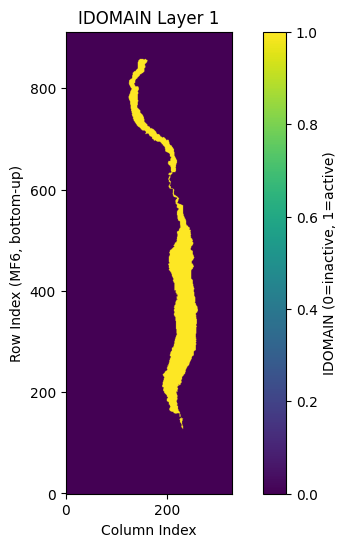

dis package created. runtime: 0.26 seconds.


In [18]:
## This cell converts the MF-OWHM RGTIHM.dis package to MODFLOW 6 rgtihm.dis, 
## First major issue is the difference in the row and col conventions, OWHM follows MF2k and MF2005 convention with xul and yul as xorigin and yorigin. MF6 uses xll and yll as xorigin and yorigin   

#fixing initial issues with an upside-down map by keeping geological data un-flipped and adjusting visualization coordinates in `grid.gpkg` with a row flip for QGIS.
# units were switched from meters back to feet to match the original MF-OWHM data, avoiding conversion errors, with `length_units="feet"` set and coordinates converted to meters for export.
# global `idomain` enforcement was added to ensure cells outside `active_area.shp` are set to 0, preventing activation by layer masks, with a final override step.
# local `idomain` assignment now respects the global mask, activating cells only where both the mask and `global_mask` are 1.
# pass-through cells (`idomain = -1`) are assigned where `botm` equals -99999 within active areas, using a tolerance check and diagnostic reporting.
# The `top` elevation is rounded up to the nearest whole number in feet using `np.ceil` to align with original data precision.
# negative cell thicknesses were fixed by checking and adjusting `botm` values to ensure a minimum thickness of 0.1 feet across all layers.
# row indices for packages like WEL are converted from MF-OWHM’s top-down to MODFLOW 6’s bottom-up convention to maintain consistency.
# diagnostics were added to monitor `idomain` outside active areas, thickness ranges, and pass-through cell counts for validation.
# made a change to read idomains from OWHM IBOUND files, and removed idomain -1 condition.  

start_time = time.time()

# model setup
model_crs = 'epsg:26913'  # define coordinate reference system
xul = 251539.8073999998  # upper-left x coordinate in feet
yul = 3639665.581800001  # upper-left y coordinate in feet
angrot = 24.0  # grid rotation angle in degrees
nlay = 9  # number of layers
nrow_owhm = 912  # number of rows from OWHM
ncol_owhm = 328  # number of columns from OWHM
nrow = nrow_owhm  # set rows for model
ncol = ncol_owhm  # set columns for model
delr = np.full(ncol, 660.0)  # cell width along rows in feet
delc = np.full(nrow, 660.0)  # cell height along columns in feet
xll = 326161.8336 / 0.3048  # lower-left x origin in feet
yll = 3472061.7670000014 / 0.3048  # lower-left y origin in feet
theta = np.radians(angrot)  # convert rotation angle to radians

# data paths
top_file = '../owhm/model/2022/Data_Model_Arrays/layers/ElevFtDEMR.txt'  # path to top elevation file
bot_files = [  # list of bottom elevation files for each layer
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_RC2_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_USF1_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_USF2_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_MSF1_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_MSF2_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/TopLSF1_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_LSF2_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/TopBSMT_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/BaseBSMT_ft.txt',
]

# load top elevation data
try:
    top = np.loadtxt(top_file, dtype=float)
    if top.shape != (nrow, ncol):
        top = top.reshape(nrow, ncol)[:nrow, :ncol]
    top = np.flipud(top)  # flip to MF6 bottom-up
    top = np.ceil(top)  # round up to nearest whole number
    print(f"Top elevation range (feet): min={np.min(top):.2f}, max={np.max(top):.2f}")
except Exception as e:
    print(f"error: loading top - {e}. exiting.")
    sys.exit(1)

# load bottom elevation data
botm = np.zeros((nlay, nrow, ncol), dtype=float)
for lay, bot_file in enumerate(bot_files):
    try:
        data = np.loadtxt(bot_file, dtype=float)
        if data.shape != (nrow, ncol):
            data = data.reshape(nrow, ncol)[:nrow, :ncol]
        botm[lay] = np.flipud(data)  # flip to MF6 bottom-up
    except Exception as e:
        print(f"error: loading bot layer {lay} - {e}. exiting.")
        sys.exit(1)

# IBOUND file paths for each layer (0-based indexing for layers)
ibound_files = {
    0: '../owhm/model/2022/Data_Model_Arrays/layers/IBOUND/L1IBOUND.txt',
    1: '../owhm/model/2022/Data_Model_Arrays/layers/IBOUND/L2IBOUND.txt',
    2: '../owhm/model/2022/Data_Model_Arrays/layers/IBOUND/L3IBOUND.txt',
    3: '../owhm/model/2022/Data_Model_Arrays/layers/IBOUND/L4IBOUND.txt',
    4: '../owhm/model/2022/Data_Model_Arrays/layers/IBOUND/L5IBOUND.txt',
    5: '../owhm/model/2022/Data_Model_Arrays/layers/IBOUND/L6IBOUND.txt',
    6: '../owhm/model/2022/Data_Model_Arrays/layers/IBOUND/L7IBOUND.txt',
    7: '../owhm/model/2022/Data_Model_Arrays/layers/IBOUND/L8IBOUND.txt',
    8: '../owhm/model/2022/Data_Model_Arrays/layers/IBOUND/L9IBOUND.txt',
}

# initialize idomain as all zeros
idomain = np.zeros((nlay, nrow, ncol), dtype=int)
print(f"Initial idomain all zeros: {np.sum(idomain == 1)}/{nlay * nrow * ncol}")

# load IBOUND data for each layer
for lay, ibound_file in ibound_files.items():
    try:
        # load IBOUND (MF-OWHM top-down order)
        ibound = np.loadtxt(ibound_file, dtype=int)
        if ibound.shape != (nrow_owhm, ncol_owhm):
            ibound = ibound.reshape(nrow_owhm, ncol_owhm)[:nrow, :ncol]
        
        # flip to MF6 bottom-up order
        ibound = np.flipud(ibound)
        
        # set idomain: 1 where ibound == 1, 0 elsewhere
        idomain[lay] = np.where(ibound == 1, 1, 0)
        print(f"Layer {lay + 1} active cells (from IBOUND): {np.sum(idomain[lay] == 1)}/{nrow * ncol}")
    except Exception as e:
        print(f"error: loading IBOUND for layer {lay + 1} - {e}. exiting.")
        sys.exit(1)

# set idomain = 0 where botm == -99999
tolerance = 1e-6  # tolerance for -99999 check
for lay in range(nlay):
    invalid_cells = np.abs(botm[lay] - (-99999)) < tolerance
    if np.any(invalid_cells):
        idomain[lay] = np.where(invalid_cells, 0, idomain[lay])
        print(f"Layer {lay + 1} active cells (after -99999 set to 0): {np.sum(idomain[lay] == 1)}/{nrow * ncol}")

# diagnostic: report active cells
for lay in range(nlay):
    print(f"Layer {lay + 1}: idomain = 1 cells: {np.sum(idomain[lay] == 1)}/{nrow * ncol}")

# create dis package
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,  
    botm=botm,  
    idomain=idomain, 
    xorigin=xll,  
    yorigin=yll,  
    angrot=angrot,
    length_units="feet"
)

# diagnostic plot of idomain layer 1 to check orientation
plt.figure(figsize=(8, 6))
plt.imshow(idomain[0], cmap="viridis", origin="lower")  # origin="lower" for MF6 bottom-up
plt.colorbar(label="IDOMAIN (0=inactive, 1=active)")
plt.title("IDOMAIN Layer 1")
plt.xlabel("Column Index")
plt.ylabel("Row Index (MF6, bottom-up)")
plt.show()

## Uncomment the following two lines if you want to write dis package alone

#dis.write()
#print("dis package written successfully.")

print(f"dis package created. runtime: {time.time() - start_time:.2f} seconds.")

### Export grid (optional)
This cells exports all 9 grid arrays for individual layers.

In [7]:
# Start time for tracking runtime
start_time = time.time()
# convert coordinates to meters for visualization (qgis expects meters)
# grid coordinates (cell centers)
x = (np.arange(ncol) + 0.5) * delr[0]  # x coordinates for cell centers
y = (np.arange(nrow) + 0.5) * delc[0]  # y coordinates for cell centers
X, Y = np.meshgrid(x, y)  # create 2d grid of x, y coordinates
X_rot = xll + X * np.cos(theta) - Y * np.sin(theta)  # rotate x coordinates
Y_rot = yll + X * np.sin(theta) + Y * np.cos(theta)  # rotate y coordinate
X_rot_m = X_rot * 0.3048  # convert x coordinates to meters
Y_rot_m = Y_rot * 0.3048  # convert y coordinates to meters
# Export grid to geopackage with 9 individual layers
points = [Point(x, y) for x, y in zip(X_rot_m.ravel(), Y_rot_m.ravel())]  # create point geometries in meters

for lay in range(nlay):
    data = []
    for row_mf6 in range(nrow):  # row_mf6 is 0-based, bottom-up (MF6 convention)
        row_owhm = nrow - row_mf6  # convert to 1-based, top-down (OWHM convention)
        for col_mf6 in range(ncol):  # col_mf6 is 0-based (MF6)
            col_owhm = col_mf6 + 1  # convert to 1-based (OWHM)
            data.append({
                'layer': lay,
                'row_mf6': row_mf6,
                'row_owhm': row_owhm,
                'col_mf6': col_mf6,
                'col_owhm': col_owhm,
                'idomain': idomain[lay, row_mf6, col_mf6],
                'top_ft': top[row_mf6, col_mf6] if lay == 0 else botm[lay - 1, row_mf6, col_mf6],  # top for layer 0, botm of layer above
                'botm_ft': botm[lay, row_mf6, col_mf6],
                'geometry': points[row_mf6 * ncol + col_mf6]
            })
    # Create GeoDataFrame for this layer
    grid_gdf = gpd.GeoDataFrame(data, crs=model_crs)
    # Export to a separate layer in the GeoPackage
    layer_name = f"layer_{lay + 1}"
    grid_gdf.to_file('./shps/grid.gpkg', driver='GPKG', layer=layer_name)
    print(f"Exported layer {lay + 1} to ./shps/grid.gpkg as {layer_name}")

print(f"Exported 9 individual grids, one for each layer in the ./shps/grid.gpkg file. Runtime: {time.time() - start_time:.2f} seconds.")

Exported layer 1 to ./shps/grid.gpkg as layer_1
Exported layer 2 to ./shps/grid.gpkg as layer_2
Exported layer 3 to ./shps/grid.gpkg as layer_3
Exported layer 4 to ./shps/grid.gpkg as layer_4
Exported layer 5 to ./shps/grid.gpkg as layer_5
Exported layer 6 to ./shps/grid.gpkg as layer_6
Exported layer 7 to ./shps/grid.gpkg as layer_7
Exported layer 8 to ./shps/grid.gpkg as layer_8
Exported layer 9 to ./shps/grid.gpkg as layer_9
Exported 9 individual grids, one for each layer in the ./shps/grid.gpkg file. Runtime: 27.00 seconds.


## Output Control (OC) Package 

In [19]:
# create oc (output control) package - defines output data to save or print
oc = flopy.mf6.ModflowGwfoc(
    gwf,  # link to groundwater flow model
    budget_filerecord=f'{sim_name}.cbc',  # set budget output file name - saves cell-by-cell budget data
    head_filerecord=f'{sim_name}.hds',  # set head output file name - saves head data
    headprintrecord=[('COLUMNS', 10, 'WIDTH', 15, 'DIGITS', 6, 'GENERAL')],  # define head printing format - columns, width, digits, and format type
    saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],  # save heads and budgets for all time steps - specifies data to save
    printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],  # print heads and budgets for all time steps - specifies data to print to listing file
)
print("oc package created.") 

oc package created.


## Iterative Model Solution (IMS) Package

In [20]:
# iterative model solutions package -- controls iterative solution of linear and nonlinear equations
#  controls solver settings
ims = flopy.mf6.ModflowIms(
    sim,  # link to simulation
    pname='ims',  # set package name
    complexity='simple',  # set solver complexity - uses simple defaults
    outer_dvclose=1e-4,  # set outer iteration closure criterion (head change)
    outer_maximum=500,  # set max number of outer iterations
    inner_maximum=100,  # set max number of inner iterations per outer iteration
    inner_dvclose=1e-4,  # set inner iteration closure criterion (head change)
    rcloserecord=0.001,  # set residual closure criterion for flow balance
    linear_acceleration='cg',  # set linear acceleration method - conjugate gradient
    relaxation_factor=0.97,  # set relaxation factor for solver stability
)

#ims.write()

print("ims package created.")  

ims package created.


## Initial Conditions (IC) Package

In [21]:
# key info: specifies initial heads for the model
# grid dimensions (from dis)
nlay = 9
nrow = 912
ncol = 328

# head file paths (relative to rgtihm-main/model)
head_files = [
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY1.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY2.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY3.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY4.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY5.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY6.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY7.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY8.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY9.txt',
]

default_head = 0.0
strt = np.ones((nlay, nrow, ncol), dtype=float) * default_head

# read heads into 3d array
for lay, head_file in enumerate(head_files):
    try:
        data = np.loadtxt(head_file, dtype=float)
        if data.shape != (nrow, ncol):
            print(f"warning: {head_file} shape {data.shape} != ({nrow}, {ncol})")
            data = data.reshape(nrow, ncol)[:nrow, :ncol]
        strt[lay] = data
    except FileNotFoundError:
        print(f"error: {head_file} not found. IC requires this file. Exiting.")
        raise FileNotFoundError(f"Error: {head_file} not found.")
    except Exception as e:
        print(f"error reading {head_file}: {e}. Exiting.")
        raise Exception(f"Error reading {head_file}: {e}")

# apply idomain from dis package
idomain = dis.idomain.array
mask_active = idomain == 1

# fix strt for active cells
top = dis.top.array
botm = dis.botm.array
for lay in range(nlay):
    active_mask = mask_active[lay]
    invalid_heads = (strt[lay] == -999) & active_mask
    if invalid_heads.any():
        default_head = (top[active_mask] + botm[lay][active_mask]) / 2 if lay == 0 else \
                       (botm[lay-1][active_mask] + botm[lay][active_mask]) / 2
        strt[lay][invalid_heads] = default_head[invalid_heads[active_mask]]
    strt[lay][active_mask] = np.clip(strt[lay][active_mask], botm[lay][active_mask], top[active_mask])

# verify strt
print("NaN in strt:", np.isnan(strt).any())
for lay in range(nlay):
    strt_active = strt[lay][mask_active[lay]]
    print(f"Layer {lay + 1} strt (active) min/max:", 
          strt_active.min() if len(strt_active) > 0 else "No active cells", 
          strt_active.max() if len(strt_active) > 0 else "No active cells")

# create ic package
ic = flopy.mf6.ModflowGwfic(gwf, strt=strt)

#ic.write()

print(f"ic package created. runtime: {time.time() - start_time:.2f} seconds")
print("ic package created with -999 treated as nodata by applying idomain from .dis")

NaN in strt: False
Layer 1 strt (active) min/max: 3690.5 4231.5
Layer 2 strt (active) min/max: 3650.0 4191.0
Layer 3 strt (active) min/max: 3554.0 5218.0
Layer 4 strt (active) min/max: 3067.5 5206.5
Layer 5 strt (active) min/max: 2691.0 5203.5
Layer 6 strt (active) min/max: 2201.5 5201.0
Layer 7 strt (active) min/max: 1796.5 5198.5
Layer 8 strt (active) min/max: 1475.0 5196.0
Layer 9 strt (active) min/max: 950.0 5476.0
ic package created. runtime: 7.92 seconds
ic package created with -999 treated as nodata by applying idomain from .dis


# Well (WEL) Package
(indludes all wells in all idomains)

In [22]:
# key info: specifies well locations and pumping rates

start_time = time.time()  # record start time
# dir
well_folder = '../owhm/model/2022/Data_FeedFiles/WEL'

# model setup (reused from DIS conversion)
model_crs = 'epsg:26913'  # UTM Zone 13N, NAD83
xul = 251539.8073999998  # upper-left x in feet
yul = 3639665.581800001  # upper-left y in feet
angrot = 24.0  # grid rotation angle in degrees
nlay = 9  # number of layers
nrow_owhm = 912  # number of rows from MF-OWHM
ncol_owhm = 328  # number of columns from MF-OWHM
nrow = nrow_owhm  # set rows for model
ncol = ncol_owhm  # set columns for model
delr = np.full(ncol, 660.0)  # cell width along rows in feet
delc = np.full(nrow, 660.0)  # cell height along columns in feet
xll = 326161.8336 / 0.3048  # lower-left x origin in feet
yll = 3472061.7670000014 / 0.3048  # lower-left y origin in feet
theta = np.radians(angrot)  # convert rotation angle to radians

# read well files
well_files = [f for f in os.listdir(well_folder) if f.endswith('_FEED.txt')]
print(f"found {len(well_files)} well files: {well_files}")

from multiprocessing import Pool

def is_float(value):
    # check if a string can be converted to float
    try:
        float(value)
        return True
    except ValueError:
        return False

def process_well_file(well_file):
    # process individual well file
    file_path = os.path.join(well_folder, well_file)
    temp_locations = []
    temp_flux = []
    reading_locations = True

    with open(file_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        if 'TEMPORAL INPUT' in line:
            reading_locations = False
            continue
        if reading_locations:
            if line.strip() and not line.startswith('#'):
                parts = line.split()
                layer_mf6 = int(parts[0]) - 1  # convert to 0-based
                row_mf6 = int(parts[1]) - 1    # convert to 0-based, assume already bottom-up
                col_mf6 = int(parts[2]) - 1    # convert to 0-based
                # validate bounds
                if layer_mf6 >= nlay or row_mf6 >= nrow or col_mf6 >= ncol:
                    print(f"warning: well {parts[3]} at mf6 ({layer_mf6}, {row_mf6}, {col_mf6}) "
                          f"exceeds grid dimensions ({nlay}, {nrow}, {ncol})")
                    continue
                well_name = parts[3].strip()
                temp_locations.append({
                    'layer_mf6': layer_mf6,
                    'row_mf6': row_mf6,
                    'col_mf6': col_mf6,
                    'name': well_name
                })
        else:
            if line.strip() and not line.startswith('#'):
                parts = line.split()
                flux = []
                for x in parts:
                    if not x.startswith('#') and is_float(x):
                        flux.append(float(x) if x.lower() != 'nan' else 0.0)
                if flux:
                    temp_flux.append(flux)

    # align flux data with locations
    if temp_flux:
        max_len = len(temp_locations)
        temp_flux = [f + [0.0] * (max_len - len(f)) if len(f) < max_len else f[:max_len] for f in temp_flux]
    else:
        temp_flux = [[0.0] * len(temp_locations) for _ in range(1)]  # at least one stress period

    unique_names_in_file = set(loc['name'] for loc in temp_locations)
    print(f"file: {well_file}, wells: {len(temp_locations)}, unique names: {unique_names_in_file}")
    return temp_locations, temp_flux

# use pool to parallelize file processing
with Pool() as p:
    results = p.map(process_well_file, well_files)

well_locations = []
flux_data = []
well_count = 0
current_well_count = 0

for temp_locations, temp_flux in results:
    well_locations.extend(temp_locations)
    new_well_count = len(temp_locations)
    if not flux_data:
        # initialize flux_data with the first temp_flux
        flux_data = [[0.0] * current_well_count + f for f in temp_flux]
    else:
        # pad existing flux_data and append new fluxes
        max_sp = max(len(flux_data), len(temp_flux))
        flux_data = [flux_data[i] + [0.0] * new_well_count if i < len(flux_data) else [0.0] * current_well_count + [0.0] * new_well_count for i in range(max_sp)]
        for i in range(len(temp_flux)):
            if i < len(flux_data):
                flux_data[i] = flux_data[i][:current_well_count] + temp_flux[i]
            else:
                flux_data.append([0.0] * current_well_count + temp_flux[i])
    current_well_count += new_well_count
    well_count += new_well_count

# identify wells outside idomain 1 (for reporting only)
comment_wells = set()
for i, well in enumerate(well_locations):
    if dis.idomain.array[well['layer_mf6'], well['row_mf6'], well['col_mf6']] != 1:
        comment_wells.add(i)
print(f"Number of wells outside idomain 1: {len(comment_wells)}")
print(f"Total wells: {well_count}")

print(f"Total flux data rows: {len(flux_data)}")
print("First 5 wells (MF6 indices):")
for well in well_locations[:5]:
    print(f"Well {well['name']}: MF6 ({well['layer_mf6']}, {well['row_mf6']}, {well['col_mf6']})")
unique_well_names = set(well['name'] for well in well_locations)
print(f"Combined unique well names: {unique_well_names}")

# prepare stress period data (include all wells)
stress_period_data = {}
previous_flux = None

for sp in range(min(nper, len(flux_data))):
    current_flux = flux_data[sp]
    if sp == 0 or current_flux != previous_flux:
        stress_period_data[sp] = []
        for idx, well in enumerate(well_locations):
            if idx < len(current_flux) and current_flux[idx] != 0.0:
                well_tuple = ((well['layer_mf6'], well['row_mf6'], well['col_mf6']), current_flux[idx], well['name'])
                stress_period_data[sp].append(well_tuple)
    previous_flux = current_flux

if not stress_period_data:
    raise ValueError("Error: stress_period_data is empty!")
else:
    for sp in range(min(nper, 5)):
        if sp in stress_period_data:
            print(f"Stress period {sp} data (MF6 indices): {stress_period_data[sp][:5]}")

# calculate MAXBOUND (maximum number of wells in any stress period)
maxbound = max(len(sp_data) for sp_data in stress_period_data.values()) if stress_period_data else 0
print(f"MAXBOUND (maximum number of wells in any stress period): {maxbound}")

# write the WEL package file directly (no commenting out wells)
wel_file = f"./model/{gwf.name}.wel"  # adjust path to model directory
with open(wel_file, 'w') as f:
    # write header
    f.write("# WEL package file generated (all wells included, no commenting)\n")
    f.write("BEGIN OPTIONS\n")
    f.write("  BOUNDNAMES\n")
    f.write("  SAVE_FLOWS\n")
    f.write("  PRINT_INPUT\n")
    f.write("END OPTIONS\n\n")

    # write dimensions block
    f.write("BEGIN DIMENSIONS\n")
    f.write(f"  MAXBOUND {maxbound}\n")
    f.write("END DIMENSIONS\n\n")

    # write stress period data
    for sp in range(min(nper, len(flux_data))):
        if sp in stress_period_data:
            f.write(f"BEGIN PERIOD {sp + 1}\n")
            for well_data in stress_period_data[sp]:
                cellid = well_data[0]  # (layer, row, col)
                flux = well_data[1]
                well_name = well_data[2]
                # write all wells without commenting
                line = f"  {cellid[0] + 1}  {cellid[1] + 1}  {cellid[2] + 1}  {flux}  {well_name}\n"
                f.write(line)
            f.write(f"END PERIOD {sp + 1}\n\n")

print(f"Wrote WEL package file to {wel_file} (all wells included, no commenting)")

# export wells to geopackage (include all wells)
# get grid information from DIS package
try:
    xll = float(dis.xorigin.data) if hasattr(dis.xorigin, 'data') else float(dis.xorigin)
except AttributeError:
    xll = float(dis.xorigin)
try:
    yll = float(dis.yorigin.data) if hasattr(dis.yorigin, 'data') else float(dis.yorigin)
except AttributeError:
    yll = float(dis.yorigin)
try:
    angrot = float(dis.angrot.data) if hasattr(dis.angrot, 'data') else float(dis.angrot)
except AttributeError:
    angrot = float(dis.angrot)

# use uniform delr and delc from DIS setup
delr = delr[0]  # uniform cell width
delc = delc[0]  # uniform cell height

# create a list of dictionaries for the GeoDataFrame
well_data = []
for idx, well in enumerate(well_locations):
    # compute x, y coordinates (center of cell) in model coordinate system (feet)
    x = xll + (well['col_mf6'] + 0.5) * delr
    y = yll + (nrow - 1 - well['row_mf6'] + 0.5) * delc  # adjust for bottom-up indexing
    
    # apply rotation
    theta = np.radians(angrot)
    x_rot = xll + (x - xll) * np.cos(theta) - (y - yll) * np.sin(theta)
    y_rot = yll + (x - xll) * np.sin(theta) + (y - yll) * np.cos(theta)
    x, y = x_rot, y_rot
    
    # convert to meters for geopackage export (QGIS expects meters)
    x_m = x * 0.3048
    y_m = y * 0.3048
    
    # collect attributes
    well_attrs = {
        'name': well['name'],
        'layer_mf6': well['layer_mf6'],
        'row_mf6': well['row_mf6'],
        'col_mf6': well['col_mf6'],
        'geometry': Point(x_m, y_m)
    }
    # add flux values for each stress period
    for sp in range(min(nper, len(flux_data))):
        flux = flux_data[sp][idx] if idx < len(flux_data[sp]) else 0.0
        well_attrs[f'flux_sp{sp}'] = flux
    well_data.append(well_attrs)

# create GeoDataFrame
gdf = gpd.GeoDataFrame(well_data, geometry='geometry')
gdf.crs = model_crs  # set CRS to match model (epsg:26913)

# export to geopackage
gdf.to_file('./shps/wells.gpkg', driver='GPKG', layer='wells')
print("Exported wells to wells.gpkg in the shps subdir")

# calculate and print runtime
end_time = time.time()
runtime = end_time - start_time
print(f"Script runtime: {runtime:.2f} seconds")

print("WEL package processing completed successfully.")

found 8 well files: ['TX_DOM_FEED.txt', 'NM_DOM_FEED.txt', 'MX_MnI_FEED.txt', 'NM_PDM_FEED.txt', 'NM_DCN_FEED.txt', 'NM_DOL_FEED.txt', 'NM_PDL_FEED.txt', 'NM_CLS_FEED.txt']


/usr/lib64/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=15125) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib64/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=15125) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib64/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=15125) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib64/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=15125) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib64/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=15125) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib64/python3.12/multiprocessi

file: MX_MnI_FEED.txt, wells: 33, unique names: {'WEL_MNI_MX'}
file: NM_CLS_FEED.txt, wells: 85, unique names: {'WEL_DOM_NM'}
file: NM_PDL_FEED.txt, wells: 73, unique names: {'WEL_DOM_NM'}
file: TX_DOM_FEED.txt, wells: 60, unique names: {'WEL_DOM_TX'}file: NM_DOL_FEED.txt, wells: 166, unique names: {'WEL_DOM_NM'}

file: NM_DCN_FEED.txt, wells: 3, unique names: {'WEL_DOM_NM'}
file: NM_PDM_FEED.txt, wells: 1308, unique names: {'WEL_DOM_NM'}
file: NM_DOM_FEED.txt, wells: 7182, unique names: {'WEL_DOM_NM'}
Number of wells outside idomain 1: 3203
Total wells: 8910
Total flux data rows: 922
First 5 wells (MF6 indices):
Well WEL_DOM_TX: MF6 (0, 661, 232)
Well WEL_DOM_TX: MF6 (0, 664, 227)
Well WEL_DOM_TX: MF6 (0, 671, 217)
Well WEL_DOM_TX: MF6 (0, 673, 227)
Well WEL_DOM_TX: MF6 (0, 674, 216)
Combined unique well names: {'WEL_MNI_MX', 'WEL_DOM_NM', 'WEL_DOM_TX'}
Stress period 0 data (MF6 indices): [((0, 664, 227), -112.480197686, 'WEL_DOM_TX'), ((0, 671, 217), -112.480197686, 'WEL_DOM_TX'), ((

## General Head Boundary (GHB) Package

In [23]:
# Model setup (from DIS)
model_crs = 'epsg:26913'  # UTM Zone 13N, NAD83
xul = 251539.8073999998  # upper-left x in feet
yul = 3639665.581800001  # upper-left y in feet
angrot = 24.0  # grid rotation angle in degrees
nlay = 9  # number of layers
nrow_owhm = 912  # number of rows from MF-OWHM
ncol_owhm = 328  # number of columns from MF-OWHM
nrow = nrow_owhm  # set rows for model
ncol = ncol_owhm  # set columns for model
delr = np.full(ncol, 660.0)  # cell width along rows in feet
delc = np.full(nrow, 660.0)  # cell height along columns in feet
xll = 326161.8336 / 0.3048  # lower-left x origin in feet
yll = 3472061.7670000014 / 0.3048  # lower-left y origin in feet
theta = np.radians(angrot)  # convert rotation angle to radians

# OWHM GHB file path
owhm_ghb_file = "../owhm/model/2022/GHB/RGTIHM.GHB"

# Read the input GHB file
with open(owhm_ghb_file, 'r') as file:
    lines = file.readlines()

# Extract GHB data based on pattern matching
ghb_pattern = re.compile(
    r'^\d+\s+\d+\s+\d+\s+[0-9.]+\s+[0-9.]+\s+(GHB_(Filmore|EPNarrow|RinconAr|MXW|MXSW|MXS|MXSE)|Filmore|EPNarrow|RinconAr|MXW|MXSW|MXS|MXSE)', 
    re.IGNORECASE
)

ghb_data = []
unmatched_lines = []
for line in lines:
    if ghb_pattern.match(line.strip()):
        # Clean up extra spaces and handle comments
        if '!' in line:
            data_parts = line.split('!')[0].strip().split()
        else:
            data_parts = line.strip().split()

        if len(data_parts) >= 6:
            # Extract layer, row, column (convert to 0-based indexing for MODFLOW 6)
            lay = int(data_parts[0]) - 1  # Adjust for 0-based indexing
            row_owhm = int(data_parts[1])  # 1-based, top-down (OWHM)
            col = int(data_parts[2]) - 1   # Convert column to 0-based
            bhead = float(data_parts[3])   # Boundary head
            cond = float(data_parts[4])    # Conductance
            boundname = data_parts[5]      # Boundname (e.g., GHB_Filmore)

            # Convert row to MODFLOW 6 bottom-up convention
            row_mf6 = nrow - 1 - (row_owhm - 1)  # 0-based, bottom-up

            # Validate bounds against grid dimensions
            if lay >= nlay or row_mf6 >= nrow or col >= ncol or lay < 0 or row_mf6 < 0 or col < 0:
                print(f"warning: GHB cell at ({lay}, {row_mf6}, {col}) exceeds grid dimensions ({nlay}, {nrow}, {ncol})")
                unmatched_lines.append(line.strip())
                continue  # Skip invalid entries

            # Format for MODFLOW 6 GHB: [(lay, row, col), bhead, cond, iface, boundname]
            iface = 1  # Default IFACE value
            ghb_data.append([(lay, row_mf6, col), bhead, cond, iface, boundname])
        else:
            unmatched_lines.append(line.strip())  # Store lines with insufficient data
    else:
        unmatched_lines.append(line.strip())  # Store non-matching lines as metadata

# Check and print unmatched lines
if unmatched_lines:
    print("These lines were skipped (didn’t match the pattern or had incorrect format):")
    for unmatched in unmatched_lines[:5]:
        print(unmatched)
    print(f"Total unmatched lines: {len(unmatched_lines)}, they are the metadata in the OWHM GHB file from line 573 onwards.")
else:
    print("All lines from the GHB file were successfully parsed.")

# Validate GHB cells against idomain
invalid_ghb_cells = []
for ghb_entry in ghb_data:
    lay, row, col = ghb_entry[0]  # Extract (lay, row, col) from GHB entry
    if dis.idomain.array[lay, row, col] != 1:
        invalid_ghb_cells.append((lay, row, col, ghb_entry[4]))  # Include boundname (now index 4)
print(f"Number of GHB cells outside idomain 1: {len(invalid_ghb_cells)}")

# Apply GHB data to all stress periods (constant conditions across all periods)
nper = sim.tdis.nper.get_data()  # Extract integer value
stress_period_data = {k: ghb_data for k in range(nper)}

# Add GHB package to existing 'gwf' object
ghb = flopy.mf6.ModflowGwfghb(
    gwf,
    pname='ghb',
    maxbound=len(ghb_data),
    stress_period_data=stress_period_data,  # GHB data for all periods
    auxiliary=[("IFACE",)],                 # IFACE auxiliary variable
    boundnames=True,                        # Preserve boundnames
    print_input=True,                       # Print input to listing file
    save_flows=True,                        # Save flows to budget file
    filename="rgtihm.ghb"
)
print(f"GHB package added to GWF model with {len(ghb_data)} boundaries across {nper} stress periods.")

# Write the GHB package
#ghb.write()

print("GHB package created.")

These lines were skipped (didn’t match the pattern or had incorrect format):
PARAMETER 10 546
BEGIN BUDGET_GROUPS
GHB_Filmore
GHB_EPNarrow
GHB_RinconAr
Total unmatched lines: 10035, they are the metadata in the OWHM GHB file from line 573 onwards.
Number of GHB cells outside idomain 1: 0
GHB package added to GWF model with 546 boundaries across 898 stress periods.
GHB package created.


### Export GHB points
Export the cells with GHB applied. Optional

In [13]:
# convert angle once
theta = np.radians(angrot)

ghb_gdf_data = []

for ghb_entry in ghb_data:
    (lay, row, col), bhead, cond, iface, boundname = ghb_entry

    # get cell width and height from delr/delc arrays
    cell_width = delr[col]
    cell_height = delc[row]

    # compute x, y (cell center) in feet
    x = xll + (col + 0.5) * cell_width
    y = yll + (row + 0.5) * cell_height

    # rotate around lower-left origin
    dx = x - xll
    dy = y - yll
    x_rot = xll + dx * np.cos(theta) - dy * np.sin(theta)
    y_rot = yll + dx * np.sin(theta) + dy * np.cos(theta)

    # convert to meters
    x_m = x_rot * 0.3048
    y_m = y_rot * 0.3048

    ghb_gdf_data.append({
        'layer_mf6': lay,
        'row_mf6': row,
        'col_mf6': col,
        'bhead': bhead,
        'conductance': cond,
        'iface': iface,
        'boundname': boundname,
        'geometry': Point(x_m, y_m)
    })

# create GeoDataFrame and export
ghb_gdf = gpd.GeoDataFrame(ghb_gdf_data, geometry='geometry', crs="EPSG:26913")
ghb_gdf.to_file('./shps/ghb.gpkg', driver='GPKG', layer='ghb', index=False)
print("exported ghb points to './shps/ghb.gpkg'")

exported ghb points to './shps/ghb.gpkg'


## Node Property Flow (NPF) Package

In [24]:
# node property flow package for k and k33
# in our case, horizontal and vertical conductivity - k11 and k22 is k, and k33 is conductivity of third ellipsoid axis - k33 tensor component
# turns out that k11 = k22 = k33 = k; since it is isotropic. we're using hk and vk.

# procedure: initialize hk, k22, k33 with small default (1e-10), populate from pval_data using zones,
# replace -99999 with default_k in active cells, set inactive cells to -99999, ensure k > 0 for active cells
# why: modflow 6 needs positive k for active cells (idomain = 1), ignores inactive cells; avoids nan for compatibility

# Use same idomain as DIS, apply to hk, k22, k33 from zones and pval_data

# zone file paths (relative to rgtihm-main/model)
zone_files = {
    'znlayrc': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/RC1_zonecode.txt',
    'znlay3': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/USF1_zonecode.txt',
    'znlay4': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/USF2_zonecode.txt',
    'znlay5': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/MSF1_zonecode.txt',
    'znlay6': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/MSF2_zonecode.txt',
    'znlay7': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/LSF1_zonecode.txt',
    'znlay8': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/LSF2_zonecode.txt',
    'znlay9': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/BSMT_zonecodeS.txt',
}

# read zone arrays
zone_arrays = {}
for name, filepath in zone_files.items():
    try:
        data = np.loadtxt(filepath, dtype=int)
        if data.shape != (nrow, ncol):
            print(f"warning: {filepath} shape {data.shape} != ({nrow}, {ncol})")
            data = data.reshape(nrow, ncol)[:nrow, :ncol]
        zone_arrays[name] = data
    except Exception as e:
        print(f"error reading {filepath}: {e}. using default zone 1.")
        zone_arrays[name] = np.ones((nrow, ncol), dtype=int)

# layer-to-zone mapping
layer_zones = {
    0: 'znlayrc', 1: 'znlayrc', 2: 'znlay3', 3: 'znlay4',
    4: 'znlay5', 5: 'znlay6', 6: 'znlay7', 7: 'znlay8', 8: 'znlay9'
}

# pval_data for hydraulic conductivity (hk and vk)
pval_data = {
    'l1hk10': 100.0, 'l1hk20': 30.0, 'l1hk30': 0.2629016, 'l1hk51': 0.14489073,
    'l2hk10': 100.0, 'l2hk20': 30.0, 'l2hk30': 0.2629016, 'l2hk51': 0.14489073,
    'l3hk15': 100.0, 'l3hk25': 100.0, 'l3hk35': 9.2195476, 'l3hk50': 30.0, 'l3hk51': 6.4479888,
    'l3hk55': 1.0, 'l3hk60': 0.17476377, 'l3hk90': 0.01,
    'l4hk15': 100.0, 'l4hk25': 100.0, 'l4hk35': 9.2195476, 'l4hk50': 30.0, 'l4hk51': 6.4479888,
    'l4hk55': 1.0, 'l4hk60': 0.17476377, 'l4hk90': 0.01,
    'l5hk35': 30.0, 'l5hk50': 0.20053775, 'l5hk55': 0.66872867, 'l5hk65': 1.0, 'l5hk90': 0.016224702,
    'l5hk100': 0.035072631,
    'l6hk25': 100.0, 'l6hk35': 30.0, 'l6hk40': 3.9352467, 'l6hk50': 0.20053775, 'l6hk55': 0.66872867,
    'l6hk65': 1.0, 'l6hk90': 0.016224702, 'l6hk100': 0.035072631,
    'l7hk35': 1.0, 'l7hk40': 2.1805362, 'l7hk55': 0.1, 'l7hk65': 0.38348569, 'l7hk90': 0.1, 'l7hk100': 0.023773051,
    'l8hk35': 1.0, 'l8hk40': 2.1805362, 'l8hk55': 0.1, 'l8hk65': 0.38348569, 'l8hk90': 0.1, 'l8hk100': 0.023773051,
    'l9hk11': 0.008606693, 'l9hk21': 0.58382645, 'l9hk31': 0.0042014914, 'l9hk41': 0.17529754, 'l9hk56': 10.0,
    'l9hk61': 0.048328901, 'l9hk71': 3.2559841,
    # vertical k (vk) for k33
    'l1vk10': 1.091422, 'l1vk20': 1.2296545, 'l1vk30': 155.00641, 'l1vk51': 1003.4731,
    'l2vk10': 1.091422, 'l2vk20': 1.2296545, 'l2vk30': 155.00641, 'l2vk51': 1003.4731,
    'l3vk15': 1.0, 'l3vk25': 10.413017, 'l3vk35': 5.2372343, 'l3vk50': 6.9875221, 'l3vk51': 8.741806,
    'l3vk55': 1358.6343, 'l3vk60': 1.0, 'l3vk90': 9.1188492,
    'l4vk15': 1.0, 'l4vk25': 10.413017, 'l4vk35': 5.2372343, 'l4vk50': 6.9875221, 'l4vk51': 8.741806,
    'l4vk55': 1358.6343, 'l4vk60': 1.0, 'l4vk90': 9.1188492,
    'l5vk35': 1.0, 'l5vk50': 5845.6619, 'l5vk55': 11.489684, 'l5vk65': 17.306335, 'l5vk90': 112.8303,
    'l5vk100': 10.288813,
    'l6vk25': 4.4199196, 'l6vk35': 1.0, 'l6vk40': 247.36765, 'l6vk50': 5845.6619, 'l6vk55': 11.489684,
    'l6vk65': 17.306335, 'l6vk90': 112.8303, 'l6vk100': 10.288813,
    'l7vk35': 2.7818614, 'l7vk40': 2.3683035, 'l7vk55': 1.2711653, 'l7vk65': 11.44632, 'l7vk90': 1.0,
    'l7vk100': 597.30784,
    'l8vk35': 2.7818614, 'l8vk40': 2.3683035, 'l8vk55': 1.2711653, 'l8vk65': 11.44632, 'l8vk90': 1.0,
    'l8vk100': 597.30784,
    'l9vk11': 1.0, 'l9vk21': 48.550788, 'l9vk31': 2.7429583, 'l9vk41': 1.9085057, 'l9vk56': 29.289344,
    'l9vk61': 1.0, 'l9vk71': 10000.0,
}

# initialize arrays with a small positive default for active cells
default_k = 1e-10  # MODFLOW requires k > 0 for active cells
hk = np.ones((nlay, nrow, ncol), dtype=float) * default_k
k22 = hk.copy()  # isotropic: k22 = hk unless specified
k33 = hk.copy()  # vertical k, defaults to hk unless vk provided
icelltype = [0] * nlay  # confined by default

# populate hk, k22, k33 from pval_data using zones
for param, value in pval_data.items():
    lay = int(param[1]) - 1  # layer index (0-based)
    iz = int(param.split('hk' if 'hk' in param else 'vk')[1])  # zone number
    zone_array = zone_arrays[layer_zones[lay]]
    mask = (zone_array == iz)
    if 'hk' in param:
        hk[lay][mask] = value
        k22[lay][mask] = value  # isotropic assumption
    elif 'vk' in param:
        k33[lay][mask] = value

# apply idomain from DIS package (already has global + layer masks + -99999 check)
idomain = dis.idomain.array
for lay in range(nlay):
    active_mask = idomain[lay] == 1
    # ensure active cells have k > 0
    hk[lay][active_mask] = np.maximum(hk[lay][active_mask], default_k)
    k22[lay][active_mask] = np.maximum(k22[lay][active_mask], default_k)
    k33[lay][active_mask] = np.maximum(k33[lay][active_mask], default_k)
    # inactive cells can keep default_k (MODFLOW ignores them)

# create NPF package
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    save_flows=True,
    icelltype=icelltype,
    k=hk,
    k22=k22,
    k33=k33,
    save_specific_discharge=True,
    alternative_cell_averaging="harmonic",
)
print(f"npf package created. runtime: {time.time() - start_time:.2f} seconds")
print("applied compound idomains, global and local for each layer. \nnpf package created from zonecode files and pvl/rgtihm.pvl")

npf package created. runtime: 73.68 seconds
applied compound idomains, global and local for each layer. 
npf package created from zonecode files and pvl/rgtihm.pvl


## Storage (STO) Package

In [25]:
## sto package

# no NaN: Replaced np.nan with defaults (ss_base = 0.000001 for SS, sy_base = 0.30 for SY) in active cells
# sentinel: Used -99999 for inactive cells (IDOMAIN = 0) instead of NaN    # dropped this method, it turned out to be idomain issue 
# defaults: Applied ss_base, sy_base where -99999 in pval_data/mult/thk for active cells, DEFAULT_MULT = 1.0 for missing mult
# validation: Ensured SS > 0, 0 <= SY <= 1 for active cells with np.maximum, np.clip
# use same idomain as DIS, apply multipliers and thickness, no sentinel values

# multiplier and thickness file paths (relative to rgtihm-main/model)
mult_files = {
    'uc_rc': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/RC1_UC.txt',
    'uc_usf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/USF1_UC.txt',
    'cf_usf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/USF1_CF.txt',
    'uc_msf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/MSF1_UC.txt',
    'cf_msf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/MSF1_CF.txt',
    'uc_lsf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/LSF1_UC.txt',
    'cf_lsf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/LSF1_CF.txt',
    'uc_bd': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/BSMT_UC.txt',
    'cf_bd': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/BSMT_CF.txt',
    'thk_rc1': '../owhm/model/2022/Data_Model_Arrays/layers/Geometry/THK_RC1_ft.txt',
    'thk_usf1': '../owhm/model/2022/Data_Model_Arrays/layers/Geometry/THK_USF1_ft.txt',
    'thk_msf1': '../owhm/model/2022/Data_Model_Arrays/layers/Geometry/THK_MSF1_ft.txt',
    'thk_lsf1': '../owhm/model/2022/Data_Model_Arrays/layers/Geometry/THK_LSF1_ft.txt',
    'thk_bd': '../owhm/model/2022/Data_Model_Arrays/layers/Geometry/THK_BSMT_ft.txt',
}

# read multiplier and thickness arrays
mult_arrays = {}
default_mult = 1.0  # default multiplier if missing
for name, filepath in mult_files.items():
    try:
        data = np.loadtxt(filepath, dtype=float)
        if data.shape != (nrow, ncol):
            print(f"warning: {filepath} shape {data.shape} != ({nrow}, {ncol})")
            data = data.reshape(nrow, ncol)[:nrow, :ncol]
        # convert thickness from ft to m, no sentinel needed
        data = data * 0.3048 if 'thk' in name else data
        mult_arrays[name] = data
    except Exception as e:
        print(f"error reading {filepath}: {e}. using default 1.0.")
        mult_arrays[name] = np.ones((nrow, ncol), dtype=float) * default_mult

# constants
ss_base = 0.000001  # default specific storage (1/m)
sy_base = 0.30      # default specific yield
phi = {'rc': 0.25, 'us': 0.22, 'ms': 0.12, 'ls': 0.08, 'bd': 0.07}  # porosity by layer group
comp_h2o = 1.432195e-06  # water compressibility (1/m)
offset = 0.0001  # avoid division by zero

# zone file paths (explicitly load here)
zone_files = {
    'znlayrc': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/RC1_zonecode.txt',
    'znlay3': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/USF1_zonecode.txt',
    'znlay4': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/USF2_zonecode.txt',
    'znlay5': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/MSF1_zonecode.txt',
    'znlay6': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/MSF2_zonecode.txt',
    'znlay7': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/LSF1_zonecode.txt',
    'znlay8': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/LSF2_zonecode.txt',
    'znlay9': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/BSMT_zonecodeS.txt',
}

# load zone arrays
zone_arrays = {}
for name, filepath in zone_files.items():
    try:
        data = np.loadtxt(filepath, dtype=int)
        if data.shape != (nrow, ncol):
            print(f"warning: {filepath} shape {data.shape} != ({nrow}, {ncol})")
            data = data.reshape(nrow, ncol)[:nrow, :ncol]
        zone_arrays[name] = data
    except Exception as e:
        print(f"error reading {filepath}: {e}. using default zone 1.")
        zone_arrays[name] = np.ones((nrow, ncol), dtype=int)

# layer-to-zone mapping
layer_zones = {
    0: 'znlayrc', 1: 'znlayrc', 2: 'znlay3', 3: 'znlay4',
    4: 'znlay5', 5: 'znlay6', 6: 'znlay7', 7: 'znlay8', 8: 'znlay9'
}

# pval_data for storage
pval_data = {
    'l2ss10': 5.0, 'l2ss20': 25.0, 'l2ss30': 8.2691995, 'l2ss51': 8.758604,
    'l3ss15': 1.0955468, 'l3ss25': 2.9409115, 'l3ss35': 3.33, 'l3ss50': 1.069701, 'l3ss51': 2.0, 'l3ss55': 10.0,
    'l3ss60': 5.1091253, 'l3ss90': 6.5520935,
    'l4ss15': 1.0955468, 'l4ss25': 2.9409115, 'l4ss35': 3.33, 'l4ss50': 1.069701, 'l4ss51': 2.0, 'l4ss55': 10.0,
    'l4ss60': 5.1091253, 'l4ss90': 6.5520935,
    'l5ss35': 0.4, 'l5ss50': 0.80498139, 'l5ss55': 1.104017, 'l5ss65': 0.5723319, 'l5ss90': 0.71704178,
    'l5ss100': 1.67,
    'l6ss25': 1.67, 'l6ss35': 0.4, 'l6ss40': 0.95152044, 'l6ss50': 0.80498139, 'l6ss55': 1.104017, 'l6ss65': 0.5723319,
    'l6ss90': 0.71704178, 'l6ss100': 1.67,
    'l7ss35': 1.2993514, 'l7ss40': 2.33, 'l7ss55': 2.33, 'l7ss65': 2.050916, 'l7ss90': 0.91998654, 'l7ss100': 1.4320346,
    'l8ss35': 1.2993514, 'l8ss40': 2.33, 'l8ss55': 2.33, 'l8ss65': 2.050916, 'l8ss90': 0.91998654, 'l8ss100': 1.4320346,
    'l9ss11': 2.33, 'l9ss21': 2.33, 'l9ss31': 0.88759879, 'l9ss41': 0.91689225, 'l9ss56': 0.667, 'l9ss61': 1.8936826,
    'l9ss71': 2.33,
    'l1sy10': 1.0, 'l1sy20': 1.0, 'l1sy30': 0.825, 'l1sy51': 1.0,
    'l3sy15': 0.50864162, 'l3sy25': 0.87375378, 'l3sy35': 0.59566227, 'l3sy50': 0.553, 'l3sy51': 0.29098953,
    'l3sy55': 0.73273826, 'l3sy60': 0.37109912, 'l3sy90': 0.2,
    'l5sy35': 0.536, 'l5sy50': 0.83810284, 'l5sy55': 1.0, 'l5sy65': 1.0, 'l5sy90': 0.51269604, 'l5sy100': 0.333,
    'l7sy35': 0.59566227, 'l7sy40': 0.88904665, 'l7sy55': 0.64751193, 'l7sy65': 0.83651446, 'l7sy90': 0.44452383,
    'l7sy100': 0.44452383,
    'l9sy11': 0.74220455, 'l9sy21': 0.333, 'l9sy31': 0.89490974, 'l9sy41': 0.87571372, 'l9sy56': 0.39531322,
    'l9sy61': 1.0, 'l9sy71': 1.0,
}

# initialize arrays with defaults for active cells
ss = np.ones((nlay, nrow, ncol), dtype=float) * ss_base
sy = np.ones((nlay, nrow, ncol), dtype=float) * sy_base
iconvert = [0] * nlay  # confined by default (adjust if needed)

# populate ss and sy with pval values
for param, value in pval_data.items():
    lay = int(param[1]) - 1
    iz = int(param.split('ss' if 'ss' in param else 'sy')[1])
    zone_array = zone_arrays[layer_zones[lay]]
    mask = (zone_array == iz)
    if 'ss' in param:
        ss[lay][mask] = value
    elif 'sy' in param:
        sy[lay][mask] = value

# apply multipliers and thickness (no sentinel values)
for lay in range(nlay):
    if lay in [0, 1]:  # rc
        thk = mult_arrays['thk_rc1']
        uc = mult_arrays['uc_rc']
        ss[lay] = np.maximum(ss[lay], (phi['rc'] * comp_h2o + ss_base) * uc)
        sy[lay] = np.clip((sy_base / (thk + offset) + phi['rc'] * comp_h2o) * uc, 0.0, 1.0)
    elif lay in [2, 3]:  # usf
        thk = mult_arrays['thk_usf1']
        uc = mult_arrays['uc_usf1']
        cf = mult_arrays['cf_usf1']
        ss[lay] = np.maximum(ss[lay], 
                             (phi['us'] * comp_h2o + ss_base) * (cf + uc) if lay == 3 else 
                             (phi['us'] * comp_h2o) * cf + ss_base * cf)
        sy[lay] = np.clip((sy_base / (thk + offset) + phi['us'] * comp_h2o) * uc, 0.0, 1.0)
    elif lay in [4, 5]:  # msf
        thk = mult_arrays['thk_msf1']
        uc = mult_arrays['uc_msf1']
        cf = mult_arrays['cf_msf1']
        ss[lay] = np.maximum(ss[lay], 
                             (phi['ms'] * comp_h2o + ss_base) * (cf + uc) if lay == 5 else 
                             (phi['ms'] * comp_h2o) * cf + ss_base * cf)
        sy[lay] = np.clip((sy_base / (thk + offset) + phi['ms'] * comp_h2o) * uc, 0.0, 1.0)
    elif lay in [6, 7]:  # lsf
        thk = mult_arrays['thk_lsf1']
        uc = mult_arrays['uc_lsf1']
        cf = mult_arrays['cf_lsf1']
        ss[lay] = np.maximum(ss[lay], 
                             (phi['ls'] * comp_h2o + ss_base) * (cf + uc) if lay == 7 else 
                             (phi['ls'] * comp_h2o) * cf + ss_base * cf)
        sy[lay] = np.clip((sy_base / (thk + offset) + phi['ls'] * comp_h2o) * uc, 0.0, 1.0)
    elif lay == 8:  # bd
        thk = mult_arrays['thk_bd']
        uc = mult_arrays['uc_bd']
        cf = mult_arrays['cf_bd']
        ss[lay] = np.maximum(ss[lay], (phi['bd'] * comp_h2o + ss_base) * (cf + uc))
        sy[lay] = np.clip((sy_base / (thk + offset) + phi['bd'] * comp_h2o) * uc, 0.0, 1.0)

# apply idomain from DIS package
idomain = dis.idomain.array
mask_active = idomain == 1

# ensure active cells have valid values
ss[mask_active] = np.maximum(ss[mask_active], ss_base)  # ss > 0
sy[mask_active] = np.clip(sy[mask_active], 0.0, 1.0)   # 0 <= sy <= 1
# inactive cells keep defaults (MODFLOW ignores them)jamia mein ao dekho kitab mela tarana 

# verify
print("ss min/max (active):", ss[mask_active].min(), ss[mask_active].max())
print("sy min/max (active):", sy[mask_active].min(), sy[mask_active].max())

# create STO package
sto = flopy.mf6.ModflowGwfsto(
    gwf,
    save_flows=True,
    iconvert=iconvert,
    ss=ss,
    sy=sy,
    transient=True,
)
#sto.write()
print(f"sto package created. runtime: {time.time() - start_time:.2f} seconds")
print("sto package created with -99999 replaced by compound idomains (global and local for each layer), -99999 for inactive cells.\nsto package created")

ss min/max (active): 1e-06 25.0
sy min/max (active): 0.0 0.9839293289640887
sto package created. runtime: 73.96 seconds
sto package created with -99999 replaced by compound idomains (global and local for each layer), -99999 for inactive cells.
sto package created


## Horizontal Flow Barrier (HFB) Package
Follows mf6 indexing convention

In [26]:
start_time = time.time()

print("Starting HFB package creation.....")

# Input file from OWHM
input_hfb_path = '../owhm/model/2022/HFB/RGTIHM.HFB'

print(f"Reading HFB input file from {input_hfb_path}.....")

tdis = sim.tdis
num_stress_periods = tdis.nper.array
nrow = dis.nrow.get_data()  # Extract integer value from MFScalar

# Read and process the HFB file
with open(input_hfb_path, 'r') as file:
    hfb_data = file.readlines()

print(f"Processing {len(hfb_data)} lines from HFB file.....")

# Dictionary to store HFB datasets
hfb_datasets = {}
current_dataset = None
current_entries = []

for line in hfb_data:
    line = line.strip()
    if not line or line.startswith(('12', 'NOPRINT')):
        continue
    
    if any(line.startswith(prefix) for prefix in ['LSF_N', 'LSF_NWNE', 'MSF_N', 'MSF_NWNE', 'PSF_NWNE', 
                                                 'Qb_MesC', 'Qb_MesE', 'Qb_MesW', 'Qb_MxW', 
                                                 'USF_N', 'USF_NWNE', 'MSF_RinMes']):
        if current_dataset and current_entries:
            hfb_datasets[current_dataset] = current_entries
        current_dataset = ' '.join(line.split()[:2])
        current_entries = []
    elif len(line.split()) == 6:
        current_entries.append(line)

if current_dataset and current_entries:
    hfb_datasets[current_dataset] = current_entries

maxhfb_valid = sum(len(entries) for entries in hfb_datasets.values())

print(f"Found {len(hfb_datasets)} HFB datasets with {maxhfb_valid} total barriers.....")

# Prepare HFB data for MODFLOW 6 (bottom-up convention)
hfb_data_list = []
idomain = dis.idomain.array
print("Converting HFB data to MODFLOW 6 format and validating against idomain.....")
for dataset_name, entries in hfb_datasets.items():
    for entry in entries:
        parts = entry.split()
        if len(parts) != 6:
            print(f"warning: skipping malformed line in {dataset_name}: {entry}")
            continue
        # Convert from OWHM (1-based, top-down) to MF6 (0-based, bottom-up)
        layer1 = int(parts[0]) - 1  # 0-based layer
        row1_owhm = int(parts[1])   # 1-based, top-down (OWHM)
        col1 = int(parts[2]) - 1    # 0-based column
        row2_owhm = int(parts[3])   # 1-based, top-down (OWHM)
        col2 = int(parts[4]) - 1    # 0-based column
        hydchr = float(parts[5])
        layer2 = layer1
        
        # Convert rows to MF6 convention
        row1_mf6 = nrow - 1 - (row1_owhm - 1)  # Invert to bottom-up
        row2_mf6 = nrow - 1 - (row2_owhm - 1)  # Invert to bottom-up
        
        if (idomain[layer1, row1_mf6, col1] > 0 and idomain[layer2, row2_mf6, col2] > 0):
            hfb_data_list.append([layer1, row1_mf6, col1, layer2, row2_mf6, col2, hydchr])

print(f"Prepared {len(hfb_data_list)} valid HFB barriers after idomain check.....")

# Create HFB package
print("Creating HFB package for MODFLOW 6.....")
hfb = flopy.mf6.ModflowGwfhfb(
    gwf,
    print_input=True,
    maxhfb=len(hfb_data_list),
    stress_period_data={period: hfb_data_list for period in range(num_stress_periods)},
    filename="rgtihm.hfb"
)

print(f"HFB package created with {len(hfb_data_list)} barriers. Runtime: {time.time() - start_time:.2f} seconds")

# Write package
#print("Writing HFB package to rgtihm.hfb.....")
#hfb.write()

print("HFB package writing completed")

Starting HFB package creation.....
Reading HFB input file from ../owhm/model/2022/HFB/RGTIHM.HFB.....
Processing 46619 lines from HFB file.....
Found 12 HFB datasets with 34932 total barriers.....
Converting HFB data to MODFLOW 6 format and validating against idomain.....
Prepared 34932 valid HFB barriers after idomain check.....
Creating HFB package for MODFLOW 6.....
HFB package created with 34932 barriers. Runtime: 758.49 seconds
HFB package writing completed


### Export HFB
Export cells with HFB condition applied for visual diagnostic. Optional.

In [17]:
# export HFB data to GeoPackage
from shapely.geometry import LineString

# get cell center coordinates in meters (from your DIS setup)
points = [Point(x, y) for x, y in zip(X_rot_m.ravel(), Y_rot_m.ravel())]  # from your grid setup

# prepare HFB data for export
hfb_export_data = []
for i, barrier in enumerate(hfb_data_list):
    layer1, row1, col1, layer2, row2, col2, hydchr = barrier
    
    # get coordinates for cell 1 and cell 2
    idx1 = row1 * ncol + col1
    idx2 = row2 * ncol + col2
    x1, y1 = points[idx1].x, points[idx1].y
    x2, y2 = points[idx2].x, points[idx2].y
    
    # create a line geometry between the two cells
    line = LineString([(x1, y1), (x2, y2)])
    
    # store data
    hfb_export_data.append({
        'barrier_id': i,
        'layer1': layer1,
        'row1': row1,
        'col1': col1,
        'layer2': layer2,
        'row2': row2,
        'col2': col2,
        'hydchr': hydchr,
        'geometry': line
    })

# create GeoDataFrame
hfb_gdf = gpd.GeoDataFrame(hfb_export_data, crs=model_crs)

# export to GeoPackage
output_path = './shps/hfb.gpkg'
hfb_gdf.to_file(output_path, driver='GPKG', layer='hfb_barriers')
print(f"Exported {len(hfb_data_list)} HFB barriers to {output_path}, layer 'hfb_barriers'")

Exported 34932 HFB barriers to ./shps/hfb.gpkg, layer 'hfb_barriers'


## Unsaturated Zone Flow (UZF) Package
We're adding this package for coupling with VIC. 
This package doesn't exist in the MF-OWHM Version of RGTIHM.

In [5]:
start_time = time.time()

# Assuming gwf is already defined (e.g., from a previous simulation load)
# get idomain from dis or gwf
idomain = gwf.modelgrid.idomain

# get active layer 1 cells
active_cells = np.argwhere(idomain[0] == 1)
nuzfcells = len(active_cells)
print(f"number of active layer-1 uzf cells: {nuzfcells}")

# build packagedata with 0-based iuzno
uzf_packagedata = []
iuzno_map = {}

# Check Bounds: Ensure thtr ≤ thti ≤ thts. If VIC’s init_moist exceeds thts * depth * 1000, cap it at 'thts'.
# Compute 'thti' per cell: thti = min(init_moist / (depth * 1000), thts).

for idx, (i, j) in enumerate(active_cells):
    iuzno = idx  # 0 to 17878
    cellid = (0, i, j)
    landflag = 1   # land surface cell
    ivertcon = 0   # vertical connection
    surfdep = 0.1  # surface depression depth
    vks = 0.5      # "Ksat" (saturated hydraulic conductivity from VIC), Col 13,14,15 (used 13)
    thtr = 0.05    # "resid_moist" from VIC (col 50)
    thts = 0.35    # derived from VIC soil parameters field bulk_density (34-36) and soil_density (37-39); 1-(bulk density/soil density), 
    thti = 0.1     # derived from "init_moist" (col 19-21), thti = init_moist / (depth * 1000). 
    eps = 4.0      # "expt" from VIC (cols 10-12), Brooks-Corey relationship. 
    uzf_packagedata.append([iuzno, cellid, landflag, ivertcon, surfdep,
                            vks, thtr, thts, thti, eps])
    iuzno_map[(i, j)] = iuzno + 1  # map stores 1-based for reference

# debug
print("packagedata sample (0-based input):")
print(f"first: {uzf_packagedata[0]}")
print(f"last: {uzf_packagedata[-1]}")

# build perioddata with 0-based iuzno
uzf_perioddata = {}
for iper in range(898):
    period_data = []
    for iuzno in range(nuzfcells):  # 0 to 17878
        finf = 0.1
        pet = 0.0
        extdp = 0.0
        extwc = 0.0
        ha = 0.0
        hroot = 0.0
        rootact = 0.0
        period_data.append([iuzno, finf, pet, extdp, extwc, ha, hroot, rootact])
    uzf_perioddata[iper] = period_data

# debug
print("perioddata sample (period 0, 0-based input):")
print(f"first: {uzf_perioddata[0][0]}")
print(f"last: {uzf_perioddata[0][-1]}")

# define budget file path
workspace = "./model"
sim_name = "rgtihm"
budget_file = os.path.abspath(os.path.join(workspace, f"{sim_name}.uzf.bud"))

# define observation output files
obs_file_uzf = os.path.join(workspace, f"{sim_name}.obs.uzf.csv")  # UZF-specific terms
obs_file_gwf = os.path.join(workspace, f"{sim_name}.obs.gwf.csv")  # GWF exchange terms

# build observation data as a dictionary
obs_data = {
    obs_file_uzf: [
        ("sinf", "infiltration", "uzfcells"),        # Total infiltration applied
        ("net-inf", "net-infiltration", "uzfcells"), # Net infiltration
        ("wc_depth1", "water-content", 1, 0.5)      # Water content at 0.5 ft depth for iuzno=1
    ],
    obs_file_gwf: [
        ("gwrch", "uzf-gwrch", "uzfcells"),         # Recharge to GWF
        ("gwd", "uzf-gwd", "uzfcells"),             # Groundwater discharge
        ("gwet", "uzf-gwet", "uzfcells")            # Groundwater ET
    ]
}

# create UZF package with observations
uzf = flopy.mf6.ModflowGwfuzf(
    gwf,
    print_input=True,
    print_flows=True,
    save_flows=True,
    budget_filerecord=budget_file,
    nuzfcells=nuzfcells,
    ntrailwaves=7,
    nwavesets=40,
    packagedata=uzf_packagedata,
    perioddata=uzf_perioddata,
    observations=obs_data,  # Updated observation block as dictionary
    obs_filerecord=f"{sim_name}.uzf.obs",  # Explicitly set obs filename
    pname="uzf",
    filename="rgtihm.uzf"
)

# write to file (uncomment if standalone uzf is required)
uzf.write()

print(f"uzf package successfully created in {time.time() - start_time:.2f} seconds.")

number of active layer-1 uzf cells: 17879
packagedata sample (0-based input):
first: [0, (0, 128, 229), 1, 0, 0.1, 0.5, 0.05, 0.35, 0.1, 4.0]
last: [17878, (0, 856, 156), 1, 0, 0.1, 0.5, 0.05, 0.35, 0.1, 4.0]
perioddata sample (period 0, 0-based input):
first: [0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
last: [17878, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
uzf package successfully created in 323.20 seconds.


### UZF with obs file fix

ERROR REPORT:

  1. Could not open "./model/rgtihm.obs.gwf.csv" on unit 1019. Specified file
     status REPLACE. Specified file format FORMATTED. Specified file access
     SEQUENTIAL. Specified file action READWRITE. IOSTAT error number 2. STOP
     EXECUTION in subroutine openfile().


In [14]:
import time
import os
import numpy as np
import flopy

start_time = time.time()

# Get idomain from dis or gwf
idomain = gwf.modelgrid.idomain

# Get active layer 1 cells
active_cells = np.argwhere(idomain[0] == 1)
nuzfcells = len(active_cells)
print(f"number of active layer-1 uzf cells: {nuzfcells}")

# Build packagedata with 0-based iuzno
uzf_packagedata = []
iuzno_map = {}
for idx, (i, j) in enumerate(active_cells):
    iuzno = idx
    cellid = (0, i, j)
    landflag = 1
    ivertcon = 0
    surfdep = 0.1
    vks = 0.5
    thtr = 0.05
    thts = 0.35
    thti = 0.1
    eps = 4.0
    uzf_packagedata.append([iuzno, cellid, landflag, ivertcon, surfdep,
                            vks, thtr, thts, thti, eps])
    iuzno_map[(i, j)] = iuzno + 1

# Debug
print("packagedata sample (0-based input):")
print(f"first: {uzf_packagedata[0]}")
print(f"last: {uzf_packagedata[-1]}")

# Build perioddata with 0-based iuzno
uzf_perioddata = {}
for iper in range(898):
    period_data = []
    for iuzno in range(nuzfcells):
        finf = 0.1
        pet = 0.0
        extdp = 0.0
        extwc = 0.0
        ha = 0.0
        hroot = 0.0
        rootact = 0.0
        period_data.append([iuzno, finf, pet, extdp, extwc, ha, hroot, rootact])
    uzf_perioddata[iper] = period_data

# Debug
print("perioddata sample (period 0, 0-based input):")
print(f"first: {uzf_perioddata[0][0]}")
print(f"last: {uzf_perioddata[0][-1]}")

# Define budget file path
budget_file = os.path.join(workspace, f"{sim_name}.uzf.bud")

# Define observation output files
obs_file_uzf = os.path.join(workspace, f"{sim_name}.obs.uzf.csv")
obs_file_gwf = os.path.join(workspace, f"{sim_name}.obs.gwf.csv")

# Build observation data as a dictionary
obs_data = {
    obs_file_uzf: [
        ("sinf", "infiltration", "uzfcells"),
        ("net-inf", "net-infiltration", "uzfcells"),
        ("wc_depth1", "water-content", 1, 0.5)
    ],
    obs_file_gwf: [
        ("gwrch", "uzf-gwrch", "uzfcells"),
        ("gwd", "uzf-gwd", "uzfcells"),
        ("gwet", "uzf-gwet", "uzfcells")
    ]
}

# Create UZF package with observations
uzf = flopy.mf6.ModflowGwfuzf(
    gwf,
    print_input=True,
    print_flows=True,
    save_flows=True,
    budget_filerecord=budget_file,
    nuzfcells=nuzfcells,
    ntrailwaves=7,
    nwavesets=40,
    packagedata=uzf_packagedata,
    perioddata=uzf_perioddata,
    observations=obs_data,
    pname="uzf",
    filename=os.path.join(workspace, "rgtihm.uzf")
)

uzf.write()

print(f"UZF package successfully created and written in {time.time() - start_time:.2f} seconds.")

number of active layer-1 uzf cells: 17879
packagedata sample (0-based input):
first: [0, (0, 128, 229), 1, 0, 0.1, 0.5, 0.05, 0.35, 0.1, 4.0]
last: [17878, (0, 856, 156), 1, 0, 0.1, 0.5, 0.05, 0.35, 0.1, 4.0]
perioddata sample (period 0, 0-based input):
first: [0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
last: [17878, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
UZF package successfully created and written in 322.12 seconds.


# UZF 
with static variables imported from the rasters exported from the VIC grid_soil_nm_003125deg

### Analyse which layer to use based on the layer thickness compared to the VIC baseflow layer 

In [37]:
# conversion factor: meters to feet
m_to_ft = 3.28084

# VIC layer depths in feet
vic_layer3_min = 0.67 * m_to_ft  # ≈ 2.198 ft
vic_layer3_max = 2.0 * m_to_ft   # ≈ 6.562 ft
print(f"VIC Layer 3 depth range: {vic_layer3_min:.3f} ft to {vic_layer3_max:.3f} ft")

# get MODFLOW grid info
nlay = gwf.dis.nlay.get_data()  # 9 layers
top = gwf.dis.top.array         # top elevation (feet)
botm = gwf.dis.botm.array       # bottom elevations (feet, shape: 9, nrow, ncol)
idomain = gwf.modelgrid.idomain # idomain array

# calculate layer thicknesses
thicknesses = np.zeros_like(botm)  # shape: (9, nrow, ncol)
# layer 1: top - botm[0]
thicknesses[0] = top - botm[0]
# layers 2-9: botm[k-1] - botm[k]
for k in range(1, nlay):
    thicknesses[k] = botm[k-1] - botm[k]

# compute statistics for active cells (idomain == 1)
stats = []
for k in range(nlay):
    # get thicknesses for active cells in layer k
    active_mask = idomain[k] == 1
    if not np.any(active_mask):
        print(f"Layer {k+1}: No active cells")
        stats.append({"layer": k+1, "mean": np.nan, "max": np.nan, "min": np.nan,
                      "q1": np.nan, "q2": np.nan, "q3": np.nan})
        continue
    active_thicknesses = thicknesses[k][active_mask]
    # calculate stats
    mean_thick = np.mean(active_thicknesses)
    max_thick = np.max(active_thicknesses)
    min_thick = np.min(active_thicknesses)
    q1_thick = np.percentile(active_thicknesses, 25)
    q2_thick = np.percentile(active_thicknesses, 50)  # median
    q3_thick = np.percentile(active_thicknesses, 75)
    stats.append({
        "layer": k+1,
        "mean": mean_thick,
        "max": max_thick,
        "min": min_thick,
        "q1": q1_thick,
        "q2": q2_thick,
        "q3": q3_thick
    })

# print statistics
print("\nMODFLOW Layer Thickness Statistics (feet):")
print(f"{'Layer':<8}{'Mean':<10}{'Max':<10}{'Min':<10}{'Q1':<10}{'Q2':<10}{'Q3':<10}")
for stat in stats:
    print(f"{stat['layer']:<8}"
          f"{stat['mean']:<10.3f}"
          f"{stat['max']:<10.3f}"
          f"{stat['min']:<10.3f}"
          f"{stat['q1']:<10.3f}"
          f"{stat['q2']:<10.3f}"
          f"{stat['q3']:<10.3f}")

# calculate depth below surface to each layer’s bottom
depths = np.zeros_like(botm)
depths[0] = top - botm[0]  # depth to bottom of layer 1
for k in range(1, nlay):
    depths[k] = depths[k-1] + (botm[k-1] - botm[k])  # cumulative depth

# stats for depth to bottom of each layer
depth_stats = []
for k in range(nlay):
    active_mask = idomain[k] == 1
    if not np.any(active_mask):
        depth_stats.append({"layer": k+1, "mean": np.nan, "max": np.nan, "min": np.nan})
        continue
    active_depths = depths[k][active_mask]
    mean_depth = np.mean(active_depths)
    max_depth = np.max(active_depths)
    min_depth = np.min(active_depths)
    depth_stats.append({"layer": k+1, "mean": mean_depth, "max": max_depth, "min": min_depth})

print("\nDepth to Bottom of Each Layer (feet):")
print(f"{'Layer':<8}{'Mean Depth':<12}{'Max Depth':<12}{'Min Depth':<12}")
for stat in depth_stats:
    print(f"{stat['layer']:<8}"
          f"{stat['mean']:<12.3f}"
          f"{stat['max']:<12.3f}"
          f"{stat['min']:<12.3f}")

# recommend UZF layer
print("\nRecommendation for UZF Layer (VIC Layer 3: 2.198 ft to 6.562 ft):")
for stat in depth_stats:
    mean_depth = stat['mean']
    if np.isnan(mean_depth):
        continue
    if mean_depth >= vic_layer3_min and mean_depth <= vic_layer3_max:
        print(f"Layer {stat['layer']} (mean depth {mean_depth:.3f} ft) matches VIC Layer 3 depth range.")
    elif mean_depth > vic_layer3_max and stat['layer'] == 1:
        print(f"Layer 1 (mean depth {mean_depth:.3f} ft) is deeper than VIC Layer 3 but closest to surface.")

VIC Layer 3 depth range: 2.198 ft to 6.562 ft

MODFLOW Layer Thickness Statistics (feet):
Layer   Mean      Max       Min       Q1        Q2        Q3        
1       50.656    110.000   50.000    50.000    50.000    51.000    
2       30.000    30.000    30.000    30.000    30.000    30.000    
3       241.632   1097.000  2.000     110.000   280.000   348.000   
4       241.351   1097.000  2.000     109.000   280.000   348.000   
5       272.589   1120.000  1.000     88.000    264.000   386.000   
6       272.544   1120.000  2.000     88.000    264.000   386.000   
7       250.811   1252.000  2.000     131.000   273.000   347.000   
8       250.811   1252.000  2.000     131.000   273.000   347.000   
9       499.998   607.000   490.000   500.000   500.000   500.000   

Depth to Bottom of Each Layer (feet):
Layer   Mean Depth  Max Depth   Min Depth   
1       50.656      110.000     50.000      
2       80.656      140.000     80.000      
3       255.436     1097.000    3.000       
4

### Export botm 1 as uzf layer to sample static variables values from the VIC epxorted and interpolated rasters

In [60]:
# grid info from DIS package
delr = gwf.dis.delr.array  # cell width along rows (feet)
delc = gwf.dis.delc.array  # cell width along columns (feet)
nrow, ncol = gwf.dis.nrow.get_data(), gwf.dis.ncol.get_data()
xorigin_feet = 326161.8336 / 0.3048  # xll in feet ≈ 1070045.387
yorigin_feet = 3472061.7670000014 / 0.3048  # yll in feet ≈ 11391343.99
xorigin_meters = 326161.8336  # xll in meters
yorigin_meters = 3472061.7670000014  # yll in meters
angrot = 24.0  # rotation angle in degrees
theta = np.radians(angrot)
cos_theta = np.cos(theta)
sin_theta = np.sin(theta)
model_crs = "EPSG:26913"  # UTM Zone 13N

# convert delr, delc to meters
delr_meters = delr / m_to_ft  # ≈ 201.168 m
delc_meters = delc / m_to_ft  # ≈ 201.168 m

# create grid of cell center coordinates (local, unrotated)
col_centers_feet = np.cumsum(delr) - delr / 2
row_centers_feet = np.cumsum(delc) - delc / 2
col_centers_meters = np.cumsum(delr_meters) - delr_meters / 2
row_centers_meters = np.cumsum(delc_meters) - delc_meters / 2
X_local_feet, Y_local_feet = np.meshgrid(col_centers_feet, row_centers_feet)
X_local_meters, Y_local_meters = np.meshgrid(col_centers_meters, row_centers_meters)

# apply rotation and translate to global coordinates
X_rot_feet = xorigin_feet + X_local_feet * cos_theta - Y_local_feet * sin_theta
Y_rot_feet = yorigin_feet + X_local_feet * sin_theta + Y_local_feet * cos_theta
X_rot_meters = xorigin_meters + X_local_meters * cos_theta - Y_local_meters * sin_theta
Y_rot_meters = yorigin_meters + X_local_meters * sin_theta + Y_local_meters * cos_theta

# export points in meters
points_meters = []
export_data_meters = []
for i, (row, col) in enumerate(active_cells):
    x = X_rot_meters[row, col]
    y = Y_rot_meters[row, col]
    points_meters.append(Point(x, y))
    export_data_meters.append({
        "cell_id": i,
        "row": row,
        "col": col
    })

gdf_meters = gpd.GeoDataFrame(export_data_meters, geometry=points_meters, crs=model_crs)
output_path_meters = "./shps/uzf_points.gpkg"
gdf_meters.to_file(output_path_meters, driver="GPKG", layer="uzf_points_meters")
print(f"Exported {len(gdf_meters)} UZF points to {output_path_meters}, layer 'uzf_points'")
print(f"Bounding box (meters): {gdf_meters.total_bounds}")

Exported 17879 UZF points to ./shps/uzf_points.gpkg, layer 'uzf_points'
Bounding box (meters): [ 282397.6186539  3514455.23623025  357824.27241746 3642271.20714767]


### Sample raster values

In [61]:
import geopandas as gpd
import rasterio
from rasterio.sample import sample_gen
import os

# uzf points gpkg 
gdf = gpd.read_file("./shps/uzf_points.gpkg")

# static variables rasters
raster_dir = "../../coupling/VIC-MF6/spatial_data/uzf_variables/"

# list of raster variable names
raster_vars = ["Ksat_1", "expt_1", "thts_1", "thti_1", "thtr_1", "vks_1", "eps_1", "resid_moist_1"]

# sample each raster
for var in raster_vars:
    raster_path = os.path.join(raster_dir, f"{var}.tif")
    with rasterio.open(raster_path) as src:
        coords = [(x,y) for x, y in zip(gdf.geometry.x, gdf.geometry.y)]
        values = [val[0] if val else None for val in src.sample(coords)]
        gdf[var] = values

# save to new file
gdf.to_file("./shps/uzf_pts_sampled.gpkg", driver="GPKG")
print(f"static variables sampled in the uzf points")


static variables sampled in the uzf points


### Create UZF Pakcage

In [58]:
import time
import flopy
import geopandas as gpd
import numpy as np
import os

start_time = time.time()

# get idomain from gwf
idomain = gwf.modelgrid.idomain

# get active layer 1 cells
active_cells = np.argwhere(idomain[0] == 1)
nuzfcells = len(active_cells)
print(f"Number of active layer-1 uzf cells: {nuzfcells}")

# read GeoPackage for static variables
gpkg_path = "./shps/uzf_pts_sampled.gpkg"
try:
    gdf = gpd.read_file(gpkg_path, layer="uzf_pts_sampled")
except Exception as e:
    raise ValueError(f"Failed to read {gpkg_path}: {e}")

if len(gdf) != nuzfcells:
    print(f"Warning: GeoPackage has {len(gdf)} points, expected {nuzfcells}")
# verify required attributes
expected_attrs = ["cell_id", "row", "col", "Ksat_1", "resid_moist", "thts", "init_moist", "expt_1"]
missing_attrs = [attr for attr in expected_attrs if attr not in gdf.columns]
if missing_attrs:
    print(f"Warning: Missing attributes in GeoPackage: {missing_attrs}")

# extract data
cell_ids = gdf["cell_id"].values
rows = gdf["row"].values.astype(int)
cols = gdf["col"].values.astype(int)
# get static variables, fill null with 0
vks = gdf.get("Ksat_1", 0).fillna(0).values  # m/day
thtr = gdf.get("resid_moist", 0).fillna(0).values  # unitless
thts = gdf.get("thts", 0).fillna(0).values  # unitless
thti = gdf.get("init_moist", 0).fillna(0).values  # unitless
eps = gdf.get("expt_1", 0).fillna(0).values  # unitless

# validate data
invalid_mask = (vks <= 0) | (thtr < 0) | (thts <= thtr) | (thti < thtr) | (thti > thts) | (eps <= 0)
if np.any(invalid_mask):
    print(f"Warning: {np.sum(invalid_mask)} cells have invalid values. Setting to defaults.")
    vks[invalid_mask] = 0.000304878  # 0.001 ft/day to m/day
    thtr[invalid_mask] = 0.05
    thts[invalid_mask] = 0.35
    thti[invalid_mask] = 0.1
    eps[invalid_mask] = 4.0

# build packagedata with 0-based iuzno
uzf_packagedata = []
iuzno_map = {}
for idx, (i, j) in enumerate(active_cells):
    iuzno = idx  # 0 to 17878
    cellid = (0, i, j)
    landflag = 1
    ivertcon = 0
    surfdep = 0.1  # meters
    uzf_packagedata.append([iuzno, cellid, landflag, ivertcon, surfdep,
                            vks[idx], thtr[idx], thts[idx], thti[idx], eps[idx]])
    iuzno_map[(i, j)] = iuzno + 1  # 1-based for reference

# debug
print("Packagedata sample (0-based input):")
print(f"First: {uzf_packagedata[0]}")
print(f"Last: {uzf_packagedata[-1]}")

# build perioddata with 0-based iuzno
uzf_perioddata = {}
for iper in range(898):
    period_data = []
    for iuzno in range(nuzfcells):
        finf = 0.0001
        pet = 0.0
        extdp = 0.0
        extwc = 0.0
        ha = 0.0
        hroot = 0.0
        rootact = 0.0
        period_data.append([iuzno, finf, pet, extdp, extwc, ha, hroot, rootact])
    uzf_perioddata[iper] = period_data

# debug
print("Perioddata sample (period 0, 0-based input):")
print(f"First: {uzf_perioddata[0][0]}")
print(f"Last: {uzf_perioddata[0][-1]}")

# define budget file path
workspace = "./model"
sim_name = "rgtihm"
budget_file = os.path.abspath(os.path.join(workspace, f"{sim_name}.uzf.bud"))

# define observation output files
obs_file_uzf = os.path.join(workspace, f"{sim_name}.obs.uzf.csv")
obs_file_gwf = os.path.join(workspace, f"{sim_name}.obs.gwf.csv")

# build observation data
obs_data = {
    obs_file_uzf: [
        ("sinf", "infiltration", "uzfcells"),
        ("net-inf", "net-infiltration", "uzfcells"),
        ("wc_depth1", "water-content", 1, 0.5)
    ],
    obs_file_gwf: [
        ("gwrch", "uzf-gwrch", "uzfcells"),
        ("gwd", "uzf-gwd", "uzfcells"),
        ("gwet", "uzf-gwet", "uzfcells")
    ]
}

# create UZF package
uzf = flopy.mf6.ModflowGwfuzf(
    gwf,
    print_input=True,
    print_flows=True,
    save_flows=True,
    budget_filerecord=budget_file,
    nuzfcells=nuzfcells,
    ntrailwaves=7,
    nwavesets=40,
    packagedata=uzf_packagedata,
    perioddata=uzf_perioddata,
    observations=obs_data,
    obs_filerecord=f"{sim_name}.uzf.obs",
    pname="uzf",
    filename="rgtihm.uzf"
)

print(f"UZF package successfully created in {time.time() - start_time:.2f} seconds.")

Number of active layer-1 uzf cells: 17879


/tmp/ipykernel_29345/2667551417.py:37: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vks = gdf.get("Ksat_1", 0).fillna(0).values  # m/day


AttributeError: 'int' object has no attribute 'fillna'

# Write Simulation
Creates the model input files in the model directory

In [27]:
# write simulation
sim.write_simulation()

# optionally run simulation (uncomment to test)
# sim.run_simulation()

print(f"simulation written directory. runtime: {time.time() - start_time:.2f} seconds")

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model rgtihm...
    writing model name file...
    writing package dis...
    writing package oc...
    writing package ic...
    writing package ghb...
    writing package npf...
    writing package sto...
    writing package hfb...
simulation written directory. runtime: 1093.42 seconds


## Figures
Plot the idomain = 1 and model grid

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon
import contextily as cx

# assume gwf and dis are already defined from your FloPy model
# extract grid coordinates from DIS package
xll = dis.xorigin.get_data()  # lower-left x (feet)
yll = dis.yorigin.get_data()  # lower-left y (feet)
angrot = dis.angrot.get_data()  # rotation angle in degrees
delr = dis.delr.get_data()  # cell widths (array in feet)
delc = dis.delc.get_data()  # cell heights (array in feet)
ncol = dis.ncol.get_data()  # number of columns
nrow = dis.nrow.get_data()  # number of rows
idomain = gwf.modelgrid.idomain  # 3D IDOMAIN array from gwf (9 layers)

# compute rotated grid coordinates (edges, not centers, for extent)
x = np.arange(ncol + 1) * delr[0]  # +1 for edges (in feet)
y = np.arange(nrow + 1) * delc[0]  # +1 for edges (in feet)
X, Y = np.meshgrid(x, y)
X_rot = xll + X * np.cos(np.radians(angrot)) - Y * np.sin(np.radians(angrot))  # in feet
Y_rot = yll + X * np.sin(np.radians(angrot)) + Y * np.cos(np.radians(angrot))  # in feet

# convert coordinates to meters for plotting (EPSG:26913 expects meters)
X_rot_m = X_rot * 0.3048  # convert feet to meters
Y_rot_m = Y_rot * 0.3048  # convert feet to meters

# compute rotated coordinates for cell centers (for contourf)
x_centers = np.arange(ncol) * delr[0] + delr[0] / 2  # cell centers in feet
y_centers = np.arange(nrow) * delc[0] + delc[0] / 2  # cell centers in feet
X_cent, Y_cent = np.meshgrid(x_centers, y_centers)
X_rot_cent = xll + X_cent * np.cos(np.radians(angrot)) - Y_cent * np.sin(np.radians(angrot))  # in feet
Y_rot_cent = yll + X_cent * np.sin(np.radians(angrot)) + Y_cent * np.cos(np.radians(angrot))  # in feet
X_rot_cent_m = X_rot_cent * 0.3048  # convert to meters
Y_rot_cent_m = Y_rot_cent * 0.3048  # convert to meters

# define model CRS
model_crs = "EPSG:26913"  # UTM Zone 13N, NAD83

# sum idomain across all 9 layers (0 to 8 in Python indexing)
idomain_sum = np.sum(idomain, axis=0)  # 2D array, values 0 to 9

# create GeoDataFrame from active cells (where sum > 0)
active_cells = np.argwhere(idomain_sum > 0)  # get (row, col) of any active cells
polygons = []

for i, j in active_cells:
    x0 = X_rot_m[i, j]  # lower-left x
    y0 = Y_rot_m[i, j]  # lower-left y
    x1 = X_rot_m[i, j + 1]  # upper-right x
    y1 = Y_rot_m[i + 1, j]  # upper-right y
    poly = Polygon([(x0, y0), (x1, y0), (x1, y1), (x0, y1), (x0, y0)])
    polygons.append(poly)

gdf_active = gpd.GeoDataFrame(geometry=polygons, crs=model_crs)

# 1. combined plot: sum of idomain with outer grid boundary
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(idomain_sum, extent=[X_rot_m.min(), X_rot_m.max(), Y_rot_m.min(), Y_rot_m.max()], 
               cmap='viridis', alpha=0.5)  # viridis to show 0-9 gradient
gdf_active.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2)

# plot only the outer boundary of the grid
# top boundary (row 0)
ax.plot(X_rot_m[0, :], Y_rot_m[0, :], 'k-', lw=1.5)
# bottom boundary (row nrow)
ax.plot(X_rot_m[nrow, :], Y_rot_m[nrow, :], 'k-', lw=1.5)
# left boundary (col 0)
ax.plot(X_rot_m[:, 0], Y_rot_m[:, 0], 'k-', lw=1.5)
# right boundary (col ncol)
ax.plot(X_rot_m[:, ncol], Y_rot_m[:, ncol], 'k-', lw=1.5)

cx.add_basemap(ax, crs=model_crs, source=cx.providers.OpenStreetMap.Mapnik)
plt.colorbar(im, ax=ax, label='Number of Active Layers')
ax.set_title('Sum of IDOMAIN Across All Layers with Grid Boundary')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
plt.tight_layout()
plt.show()

# load top elevation from gwf
top_elev = gwf.dis.top.get_data()  # 2D array in feet

# debug: check elevation data
print("top elevation shape:", top_elev.shape)
print("top elevation min (ft):", np.nanmin(top_elev))
print("top elevation max (ft):", np.nanmax(top_elev))
print("number of NaNs in top elevation:", np.isnan(top_elev).sum())

# convert elevation to meters
top_elev_m = top_elev * 0.3048  # feet to meters

# 2. rotated plot (no basemap, using contourf)
fig, ax = plt.subplots(figsize=(10, 10))
cf = ax.contourf(X_rot_cent_m, Y_rot_cent_m, top_elev_m, cmap='terrain', levels=20)
plt.colorbar(cf, ax=ax, label='Top Elevation (m)')
ax.set_title('Top Layer Elevation (Rotated, No Basemap)')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

# 3. rotated plot with basemap
fig, ax = plt.subplots(figsize=(10, 10))
cf = ax.contourf(X_rot_cent_m, Y_rot_cent_m, top_elev_m, cmap='terrain', levels=20, alpha=0.8)
try:
    cx.add_basemap(ax, crs=model_crs, source=cx.providers.OpenStreetMap.Mapnik)
except Exception as e:
    print("basemap failed to load:", e)
plt.colorbar(cf, ax=ax, label='Top Elevation (m)')
ax.set_title('Top Layer Elevation')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

## XS Plots

In [ ]:
# Cross-sections for rows 538, 741, 103 (MF-OWHM convention), and column 75 (MF-OWHM convention)
rows_owhm = [538, 741, 103]  # 1-based, top-down (MF-OWHM)
col_owhm = 75  # 1-based (MF-OWHM)

# Convert MF-OWHM indices to MODFLOW 6 indices
# Assuming nrow_owhm and ncol_owhm are defined (from DIS setup)
nrow_owhm = 912
ncol_owhm = 328

# Transform rows (top-down, 1-based to bottom-up, 0-based)
rows_mf6 = [nrow_owhm - 1 - (row - 1) for row in rows_owhm]
# Transform column (1-based to 0-based, no flipping needed for columns)
col_mf6 = col_owhm - 1

# Print the conversions for reference
for row_owhm, row_mf6 in zip(rows_owhm, rows_mf6):
    print(f"MF-OWHM row {row_owhm} -> MODFLOW 6 row {row_mf6}")
print(f"MF-OWHM col {col_owhm} -> MODFLOW 6 col {col_mf6}")

layer_names = ["top rc2", "top usf1", "top usf2", 
               "top msf1", "top msf2", "top lsf1", "top lsf2", 
               "top bsmt", "bsmt_botm"]

print("botm shape:", botm.shape)
print("top shape:", top.shape)
print("x_rot shape:", X_rot.shape)
print("y_rot shape:", Y_rot.shape)

# No-data sentinel in feet (corrected from -30479.6952 meters)
no_data_sentinel = -99999
tolerance = 1.0  # tolerance in feet to catch floating-point variations

# Debug function to check for sentinel values
def check_sentinel(data, sentinel, label):
    close_to_sentinel = np.any(np.abs(data - sentinel) < tolerance)
    exact_sentinel = np.any(data == sentinel)
    print(f"{label}: contains exact {sentinel}={exact_sentinel}, close to {sentinel}={close_to_sentinel}")

# Plot cross-sections for each row
for row_owhm, row_mf6 in zip(rows_owhm, rows_mf6):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [3, 1]})

    x_trimmed = X_rot[row_mf6, :ncol]
    for lay, name in zip(range(nlay), layer_names):
        bot = botm[lay, row_mf6, :]
        check_sentinel(bot, no_data_sentinel, f"Row OWHM {row_owhm} (MF6 {row_mf6}), Layer {name}")
        bot_plot = np.where(np.abs(bot - no_data_sentinel) < tolerance, np.nan, bot)
        ax1.plot(x_trimmed, bot_plot, label=name)

    top_data = top[row_mf6, :]
    check_sentinel(top_data, no_data_sentinel, f"Row OWHM {row_owhm} (MF6 {row_mf6}), Top")
    top_plot = np.where(np.abs(top_data - no_data_sentinel) < tolerance, np.nan, top_data)
    ax1.plot(x_trimmed, top_plot, 'k-', label='elev')

    inactive_cells = [(name, (idomain[lay, row_mf6, :] == 0).sum()) for lay, name in enumerate(layer_names)]
    print(f"inactive cells in row OWHM {row_owhm} (MF6 {row_mf6}): {inactive_cells}")

    botm_base = np.where(np.abs(botm[-1, row_mf6, :] - no_data_sentinel) < tolerance, np.nan, botm[-1, row_mf6, :])
    top_fill = np.where(np.abs(top[row_mf6, :] - no_data_sentinel) < tolerance, np.nan, top[row_mf6, :])
    valid_mask = ~np.isnan(botm_base) & ~np.isnan(top_fill)
    ax1.fill_between(x_trimmed[valid_mask], botm_base[valid_mask], top_fill[valid_mask], color='gray', alpha=0.3)

    ax1.set_title(f'cross-section (row OWHM {row_owhm}, MF6 {row_mf6})')
    ax1.set_xlabel('easting (ft)')  # Changed to feet to match data
    ax1.set_ylabel('elevation (ft)')  # Changed to feet to match data
    ax1.legend()

    # Convert to meters for location map
    ax2.imshow(idomain[0], extent=[X_rot.min() * 0.3048, X_rot.max() * 0.3048, Y_rot.min() * 0.3048, Y_rot.max() * 0.3048], 
               cmap='binary', alpha=0.5)
    gdf.plot(ax=ax2, edgecolor='red', facecolor='none', linewidth=2)
    cx.add_basemap(ax=ax2, crs=model_crs, source=cx.providers.OpenStreetMap.Mapnik)
    ax2.plot(X_rot[row_mf6, :] * 0.3048, Y_rot[row_mf6, :] * 0.3048, 'b-', lw=2, label='cross-section line')
    ax2.set_title('location map')
    ax2.legend()
    ax2.set_xticks([])
    ax2.set_yticks([])
    plt.tight_layout()
    plt.show()

# Plot cross-section for the column
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [3, 1]})

y_trimmed = Y_rot[:nrow, col_mf6]
for lay, name in zip(range(nlay), layer_names):
    bot = botm[lay, :, col_mf6]
    check_sentinel(bot, no_data_sentinel, f"Col OWHM {col_owhm} (MF6 {col_mf6}), Layer {name}")
    bot_plot = np.where(np.abs(bot - no_data_sentinel) < tolerance, np.nan, bot)
    ax1.plot(y_trimmed, bot_plot, label=name)

top_data = top[:, col_mf6]
check_sentinel(top_data, no_data_sentinel, f"Col OWHM {col_owhm} (MF6 {col_mf6}), Top")
top_plot = np.where(np.abs(top_data - no_data_sentinel) < tolerance, np.nan, top_data)
ax1.plot(y_trimmed, top_plot, 'k-', label='elev')

inactive_cells_col = [(name, (idomain[lay, :, col_mf6] == 0).sum()) for lay, name in enumerate(layer_names)]
print(f"inactive cells in column OWHM {col_owhm} (MF6 {col_mf6}): {inactive_cells_col}")

botm_base = np.where(np.abs(botm[-1, :, col_mf6] - no_data_sentinel) < tolerance, np.nan, botm[-1, :, col_mf6])
top_fill = np.where(np.abs(top[:, col_mf6] - no_data_sentinel) < tolerance, np.nan, top[:, col_mf6])
valid_mask = ~np.isnan(botm_base) & ~np.isnan(top_fill)
ax1.fill_between(y_trimmed[valid_mask], botm_base[valid_mask], top_fill[valid_mask], color='gray', alpha=0.3)

ax1.set_title(f'cross-section (column OWHM {col_owhm}, MF6 {col_mf6})')
ax1.set_xlabel('northing (ft)')  # Changed to feet to match data
ax1.set_ylabel('elevation (ft)')  # Changed to feet to match data
ax1.legend()

# Convert to meters for location map
ax2.imshow(idomain[0], extent=[X_rot.min() * 0.3048, X_rot.max() * 0.3048, Y_rot.min() * 0.3048, Y_rot.max() * 0.3048], 
           cmap='binary', alpha=0.5)
gdf.plot(ax=ax2, edgecolor='red', facecolor='none', linewidth=2)
cx.add_basemap(ax=ax2, crs=model_crs, source=cx.providers.OpenStreetMap.Mapnik)
ax2.plot(X_rot[:, col_mf6] * 0.3048, Y_rot[:, col_mf6] * 0.3048, 'b-', lw=2, label='cross-section line')
ax2.set_title('location map')
ax2.legend()
ax2.set_xticks([])
ax2.set_yticks([])
plt.tight_layout()
plt.show()